# Test diffusion, force balences, and binding for two actins and a cross-linker
Let's look at actin and actinin locations under some simple diffusion, binding, and stretching regiems. We're going to minimally-outsource this, meaning that this will be longer and less abstracted implementation with repeats, in order to make the exploration explicit. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

import stress_fiber as sf

In [2]:
act_a = sf.Actin(0, 100, None)
act_b = sf.Actin(40, 100, None)

bs_aa = act_a.sites[0]   # for anchor
bs_ab = act_a.sites[40]  # for α-actinin
bs_ba = act_b.sites[-1]  # for anchor
bs_bb = act_b.sites[12]  # for α-actinin

alph = sf.AlphaActinin(bs_ab.x, None)

#Link the two actin filaments via the actinin
alph.heads[0].binding_site = bs_ab
alph.heads[1].binding_site = bs_bb
bs_ab.link = alph.heads[0]
bs_bb.link = alph.heads[1]

Let's look at where the actin ends up if we just let it step through time without a chance for the α-actinin to unbind

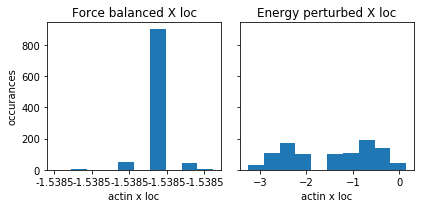

In [3]:
# Record post-force-balance and post-energy-perturbation locations
fex = []
for i in range(1000):
    fex.append(act_a.step())
force_x, energy_x = zip(*fex)

# Plot it up
fig, ax = plt.subplots(1,2,figsize=(6,3), sharey=True)
ax[0].hist(force_x)
ax[0].set(title="Force balanced X loc",
          xlabel="actin x loc",
          ylabel="occurances"
         )
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
ax[1].hist(energy_x)
ax[1].set(title="Energy perturbed X loc",
          xlabel="actin x loc"
         )
plt.tight_layout()

So we have the minimal-force location as a constant(to machine precision more or less) and the energy-perturbed location as slightly to one side or the other of the minimal-force location. That is consistant with what we'd expect out of a "move to minimal force x loc and then bop around" force balance and diffusion scheme. 

Now we'll add an anchor to hold both actins where we want them.

In [4]:
anc_a = sf.Anchor(bs_aa.x)
bs_aa.link = anc_a
anc_a.binding_site = bs_aa

anc_b = sf.Anchor(bs_ba.x)
bs_ba.link = anc_b
anc_b.binding_site = bs_ba

And perform the same bop-around test as above, this time with the expectation that the anchors are going to be holding the system fast.

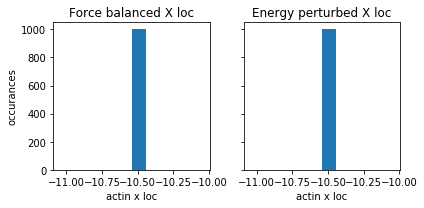

In [5]:
# Record post-force-balance and post-energy-perturbation locations
fex = []
for i in range(1000):
    fex.append(act_a.step())
force_x, energy_x = zip(*fex)

# Plot it up
fig, ax = plt.subplots(1,2,figsize=(6,3), sharey=True)
ax[0].hist(force_x)
ax[0].set(title="Force balanced X loc",
          xlabel="actin x loc",
          ylabel="occurances"
         )
ax[1].hist(energy_x)
ax[1].set(title="Energy perturbed X loc",
          xlabel="actin x loc"
         )
plt.tight_layout()

Cool, so they are locked down. Let's take a look at what happens to the location of our actin filament if we slowly move the anchor over time. 

In [6]:
initial_x = anc_b.x
x_range = np.linspace(initial_x-5, initial_x+5, 100) 
anc_a_x = []
anc_b_x = []
fex_a = []
fex_b = []
for x in x_range:
    for i in range(10):
        anc_b.x = x
        anc_a_x.append(anc_a.x)
        anc_b_x.append(anc_b.x)
        fex_a.append(act_a.step())
        fex_b.append(act_b.step())
_, act_a_x = zip(*fex_a)
_, act_b_x = zip(*fex_b)

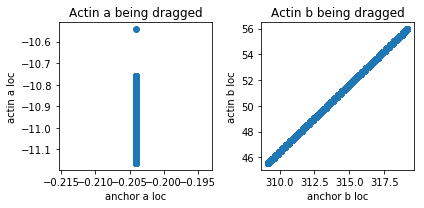

In [7]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].plot(anc_a_x, act_a_x, 'o')
ax[0].set(title="Actin a being dragged",
          xlabel="anchor a loc",
          ylabel="actin a loc",
         )
ax[1].plot(anc_b_x, act_b_x, 'o')
ax[1].set(title="Actin b being dragged",
          xlabel="anchor b loc",
          ylabel="actin b loc",
         )
plt.tight_layout()

This is good. It means that our `anc_a` is holding our `act_a` pretty tightly, letting `act_a` be dragged ~0.2nm while `act_b` is being dragged pretty much straight along with `anc_b` as it is moved by fiat. We get a blip in the location as we move a whole bunch to reach the first x-location, but that is to be expected as that is a large `dx`.

Next we'll look at the energy in our α-actinin and the rate of unbinding it would expereience along this range of x offsets. 

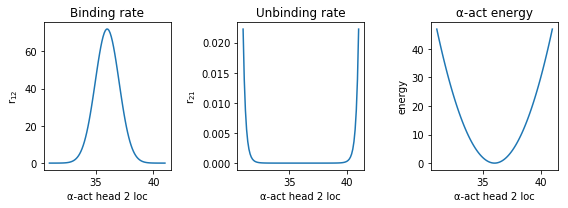

In [8]:
## Create our fake actinin
alph = sf.AlphaActinin(0, None)
ah1, ah2 = alph.heads

## Fake binding sites to control actinin head loc
class FakeBS:
    def __init__(self, x):
        self.x = x
        return
fbs1, fbs2 = FakeBS(0), FakeBS(alph.spring.rest)
ah1.binding_site, ah2.binding_site = fbs1, fbs2

## Set up range
initial_x = fbs2.x
x_range = np.linspace(initial_x-5, initial_x+5, 100) 
# Record the binding rates across this range, for which we don't move the head since we are looking at distance dependence
r12 = [ah2._r12(abs(x-initial_x)) for x in x_range]
# Record the energies and unbinding rates, for which move the head
alph_energy = []
r21 = []
for x in x_range:
    fbs2.x = x
    alph_energy.append(alph.energy)
    r21.append(ah2._r21())
    
## Plot it up
fig, ax = plt.subplots(1,3,figsize=(8,3),sharex=True)
ax[0].plot(x_range, r12)
ax[0].set(title="Binding rate", ylabel='r$_{12}$', xlabel='α-act head 2 loc')
ax[1].plot(x_range, r21)
ax[1].set(title="Unbinding rate", ylabel='r$_{21}$', xlabel='α-act head 2 loc')
ax[2].plot(x_range, alph_energy)
ax[2].set(title="α-act energy", ylabel='energy', xlabel='α-act head 2 loc')
plt.tight_layout()

This is what I expected. Note that the unbinding rate quickly increases to a rate that all-but-assures unbinding as we stretch beyond these limits. 